# google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Loading Embedding_matrix & Vocab

In [2]:
import numpy as np
import pickle

# Read dictionary pkl file
with open("/content/gdrive/My Drive/matrices/vocab.pkl", 'rb') as fp:
    vocab= pickle.load(fp)

matrix_name = "Glove_embedding_matrix.npy"
path= F"/content/gdrive/My Drive/matrices/{matrix_name}"

embedding_matrix = np.load(path)


In [3]:
vocab_size = np.shape(embedding_matrix)[0]
embedding_dim = np.shape(embedding_matrix)[1]

# Dataset Loading

## Emotion

In [4]:
import pandas as pd

In [5]:
ds_name = "emotion_train.csv"
path= F"/content/gdrive/My Drive/Database/{ds_name}"
ds = pd.read_csv(path)

In [6]:
emotion_text = ds['text']
emotion_label = ds['label']

In [7]:
import sklearn
import numpy
import tensorflow as tf

In [8]:
b = emotion_text[0]
b = str.split(b, ' ')
b = [i for i in b if not '@' in i]
print(b)

['i', 'dont', 'understand', 'why', 'u', 'do', 'videos', 'every', 'week', 'spend', 'time', 'with', 'your', 'family', 'instead', 'of', 'working', 'on', 'horror', '#takeabreak']


## Yelp

In [9]:
ds_name = "yelp_train.csv"
path= F"/content/gdrive/My Drive/Database/{ds_name}"
ds = pd.read_csv(path)

In [10]:
yelp_text = ds['text']
yelp_label = ds['label']

# Classification Data_preprocess & Dataset

In [11]:
class Preprocess_classification:
    def __init__(self, vocab):
      self.vocab = vocab
      self.stop_words = ['is','was','be','will','the','on','a','an','about','any','all','both','ain','after','because','at','be','before','been','can','could','during','for','to','about','just','such','then','which']

    def preprocess_sentence(self, w):
      import re
      #Lower
      w = w.lower().strip()

      # removing @s (for tweets)
      w = str.split(w,' ')
      w = [x for x in w if not '@' in x]
      w = ' '.join(w)

      # creating a space between a word and the punctuation following it
      w = re.sub(r"([?.!,¿:])", r" \1 ", w)
      w = re.sub(r'[" "]+', " ", w)

      # replacing everything with space except (a-z, A-Z,":", "?", "!", ",")
      w = re.sub(r"[^a-zA-Z?!,¿:]+", " ", w)

      # removing stop-words
      w = str.split(w,' ')
      w = [x for x in w if not x in self.stop_words]
      w = ' '.join(w)

      # outputting the (Glove)vocab values
      w = w.split()
      w = [word if word in self.vocab else '' for word in w]
      Out = [self.vocab[word] for word in w if word!= '']
      return Out

    def create_dataset(self, text, label, max_len, buffer_size, batch_size):
      Text = np.array([self.preprocess_sentence(w) for w in text])
      Label = np.array(label)

      # padding
      Text = tf.keras.preprocessing.sequence.pad_sequences(Text, maxlen= max_len, padding='post')

      train_dataset = tf.data.Dataset.from_tensor_slices((Text, Label))
      train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

      return train_dataset

In [12]:
# For EI_emotion
buffer_size_emotion = 4000
batch_size = 64
max_len = 25

preprocess = Preprocess_classification(vocab)
train_emotion = preprocess.create_dataset(emotion_text, emotion_label, max_len, buffer_size_emotion, batch_size)

<ipython-input-11-79cb1ed4c48f>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Text = np.array([self.preprocess_sentence(w) for w in text])


In [13]:
buffer_size_sentiment = 5100

train_sentiment = preprocess.create_dataset(yelp_text, yelp_label, max_len, buffer_size_sentiment, batch_size)

<ipython-input-11-79cb1ed4c48f>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Text = np.array([self.preprocess_sentence(w) for w in text])


In [14]:
example_input_batch_emotion, example_target_batch_emotion = next(iter(train_emotion))
example_input_batch_emotion.shape, example_target_batch_emotion.shape

(TensorShape([64, 25]), TensorShape([64]))

# Base Model

In [15]:
# Basic Classifier class

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense

class Basic_Classifier(tf.keras.Model):
  def __init__(self, units, batch_size, num_classes, recurrent_dropout= 0.3):
    super(Basic_Classifier, self).__init__()
    self.batch_size = batch_size
    self.units = units
    self.recurrent_dropout = recurrent_dropout
    self.num_classes = num_classes

    self.embedding_layer = tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=True)

    self.lstm_layer = tf.keras.layers.LSTM(self.units, return_sequences= True, return_state= True, recurrent_dropout= self.recurrent_dropout)
    self.linear_layer = Dense(units=32, activation='relu')
    self.softmax_layer = Dense(units=self.num_classes, activation='softmax')


  def call(self, x, hidden):
    x = self.embedding_layer(x)

    output, h, c = self.lstm_layer(x, initial_state= hidden)
    dropout_hidden = tf.keras.layers.Dropout(rate=0.3)(h)

    linear = self.linear_layer(h)
    dropout_linear = tf.keras.layers.Dropout(rate=0.2)(linear)

    softmax = self.softmax_layer(dropout_linear)
    return softmax

  def initialize_hidden_state(self, batch_size):
    return [tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units))]

In [17]:
a = Basic_Classifier(256, 64, 3)

In [ ]:
# Test
h, c = a.initialize_hidden_state(64)
a.call(example_input_batch_emotion, [h,c])

In [16]:
# Optimizer
import tensorflow as tf
optimizer = tf.keras.optimizers.legacy.Adam(0.001)

#Loss
def loss_function(real, pred):
  cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()
  loss = cross_entropy(y_true= real, y_pred= pred)
  loss = tf.reduce_mean(loss)
  return loss

In [17]:
# Defining model instances
batch_size = 64
classifier_emotion_base = Basic_Classifier(batch_size= batch_size, units= 256, num_classes= 4)
classifier_sentiment_base = Basic_Classifier(batch_size= batch_size, units= 256, num_classes= 3)

In [18]:
steps_emotion= len(emotion_text)//batch_size
steps_sentiment = len(yelp_text)//batch_size

In [19]:
def train_step_base(model, text, label):
  h, c = model.initialize_hidden_state(batch_size)
  with tf.GradientTape() as tape:
    out_probs = model.call(text, [h,c])

    predicted_labels = tf.argmax(out_probs, axis=-1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(label, predicted_labels), dtype=tf.float32))
    # Loss
    loss = loss_function(label, out_probs)
    # Get the watched variables
    variables = model.trainable_variables

    # Compute gradients only for watched variables
    gradients = tape.gradient(loss, variables)

    # Apply gradients to the watched variables
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, accuracy

In [20]:
def train_epoch_base(model, data_set, steps, epochs):
  losses = []
  accuracies = []
  for epoch in range(epochs):
    total_loss = 0
    total_accuracy = 0
    for (batch, (text, label)) in enumerate(data_set.take(steps)):
      batch_loss, batch_accuracy = train_step_base(model, text, label)
      total_loss += batch_loss
      total_accuracy += batch_accuracy
    print('Epoch {} Loss {:.4f}'.format(epoch+1,
                                        total_loss / steps))
    print('Epoch {} Accuracy {:.4f}'.format(epoch+1,
                                        total_accuracy ))
    losses.append(total_loss/steps)
    accuracies.append(total_accuracy/steps)

  return losses, accuracies

In [21]:
losses_emotion_base, accuracies_emotion_base = train_epoch_base(classifier_emotion_base, train_emotion, len(emotion_text)//batch_size, 14)

Epoch 1 Loss 1.0889
Epoch 1 Accuracy 33.9062
Epoch 2 Loss 0.7113
Epoch 2 Accuracy 47.4531
Epoch 3 Loss 0.5281
Epoch 3 Accuracy 52.1562
Epoch 4 Loss 0.3837
Epoch 4 Accuracy 55.9844
Epoch 5 Loss 0.3002
Epoch 5 Accuracy 58.0156
Epoch 6 Loss 0.2511
Epoch 6 Accuracy 58.6406
Epoch 7 Loss 0.2039
Epoch 7 Accuracy 59.6406
Epoch 8 Loss 0.1841
Epoch 8 Accuracy 59.9531
Epoch 9 Loss 0.1658
Epoch 9 Accuracy 60.2812
Epoch 10 Loss 0.1550
Epoch 10 Accuracy 60.2188
Epoch 11 Loss 0.1455
Epoch 11 Accuracy 60.4375
Epoch 12 Loss 0.1390
Epoch 12 Accuracy 60.5781
Epoch 13 Loss 0.1382
Epoch 13 Accuracy 60.3281
Epoch 14 Loss 0.1287
Epoch 14 Accuracy 60.2656


In [22]:
losses_sentiment_base, accuracies_sentiment_base = train_epoch_base(classifier_sentiment_base, train_sentiment, len(yelp_text)//batch_size, 14)

Epoch 1 Loss 0.9767
Epoch 1 Accuracy 42.7344
Epoch 2 Loss 0.7452
Epoch 2 Accuracy 53.2812
Epoch 3 Loss 0.5604
Epoch 3 Accuracy 59.3281
Epoch 4 Loss 0.4056
Epoch 4 Accuracy 65.7188
Epoch 5 Loss 0.2591
Epoch 5 Accuracy 70.5000
Epoch 6 Loss 0.1530
Epoch 6 Accuracy 73.7500
Epoch 7 Loss 0.0938
Epoch 7 Accuracy 75.7812
Epoch 8 Loss 0.0557
Epoch 8 Accuracy 76.6562
Epoch 9 Loss 0.0293
Epoch 9 Accuracy 77.3281
Epoch 10 Loss 0.0172
Epoch 10 Accuracy 77.5938
Epoch 11 Loss 0.0179
Epoch 11 Accuracy 77.5781
Epoch 12 Loss 0.0092
Epoch 12 Accuracy 77.8594
Epoch 13 Loss 0.0100
Epoch 13 Accuracy 77.7656
Epoch 14 Loss 0.0045
Epoch 14 Accuracy 77.9062


# LN-LSTM Encoder cell

In [23]:

import tensorflow as tf

# To DO: trainability of layers (for fine-tuning)
class LNLSTMCell(tf.keras.Model):
    def __init__(self, embedding_dim, hidden_size, trainable=True, dropout=0.3):
        super(LNLSTMCell, self).__init__()
        self.input_size = embedding_dim
        self.hidden_size = hidden_size
        self.trainable = trainable

        # Layer Normalization
        self.ln_emotion_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_emotion_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_emotion_c = tf.keras.layers.LayerNormalization(axis=1)

        self.ln_sentiment_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_sentiment_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_sentiment_c = tf.keras.layers.LayerNormalization(axis=1)

        self.ln_new_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_new_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_new_c = tf.keras.layers.LayerNormalization(axis=1)

        # Dropout
        self.dropout_layer = tf.keras.layers.Dropout(rate= dropout)

        self.embedding_layer = tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dim,
          weights=[embedding_matrix],
          mask_zero=True,
          trainable=True)

        # LSTM parameters
        self.weight_ih = self.add_weight(shape=(self.input_size, 4 * hidden_size), trainable= self.trainable)
        self.weight_ih_with_dropout = self.dropout_layer(self.weight_ih)
        self.weight_hh = self.add_weight(shape=(hidden_size, 4 * hidden_size), trainable= self.trainable)
        self.weight_hh_with_dropout = self.dropout_layer(self.weight_hh)
        self.bias = self.add_weight(shape=(4 * hidden_size,), trainable= self.trainable)
        self.bias_with_dropout = self.dropout_layer(self.bias)


    def call(self, task, input_, hx):
        h, c = hx
        if task == 'emotion':
          ln_x = self.ln_emotion_x
          ln_h = self.ln_emotion_h
          ln_c = self.ln_emotion_c

        elif task == 'sentiment':
          ln_x = self.ln_sentiment_x
          ln_h = self.ln_sentiment_h
          ln_c = self.ln_sentiment_c

        elif task == 'new':
          ln_x = self.ln_new_x
          ln_h = self.ln_new_h
          ln_c = self.ln_new_c
        else:
          raise ValueError('Key Error')

        input = self.embedding_layer(input_)

        # Create a mask for the input based on non-zero values
        mask = tf.math.not_equal(input_, 0)
        mask = tf.cast(mask, dtype=input.dtype)
        # Broadcast the mask to match the shape of gates
        mask = tf.expand_dims(mask, axis=-1)


        gates = ln_x(tf.matmul(input, self.weight_ih_with_dropout)) + ln_h(tf.matmul(h, self.weight_hh_with_dropout)) + self.bias_with_dropout


        # Split the gates into input, forget, cell, and output gates
        input_gate, forget_gate, cell_gate, output_gate = tf.split(gates, 4, axis=-1)

        # Apply sigmoid activation to the gates
        input_gate = tf.sigmoid(input_gate)
        forget_gate = tf.sigmoid(forget_gate)
        cell_gate = tf.tanh(cell_gate)
        output_gate = tf.sigmoid(output_gate)

        # Update the cell and hidden state
        c_new = c * forget_gate + input_gate * cell_gate
        c_new = c_new * mask + c * (1 - mask)  # Masked cell state remains unchanged
        h_new = output_gate * tf.tanh(ln_c(c_new))
        h_new = h_new * mask + h * (1 - mask)  # Masked hidden state remains unchanged

        return h_new, c_new

    def initialize_hidden_state(self, batch_size):
      return [tf.zeros((batch_size, self.hidden_size)), tf.zeros((batch_size, self.hidden_size))]


In [24]:
ln_lstm = LNLSTMCell(embedding_dim= embedding_dim, hidden_size= 256, trainable=True)
x = example_input_batch_emotion[:, 0]
initial = ln_lstm.initialize_hidden_state(batch_size=batch_size)

h, c = ln_lstm.call('new',x, initial)

# MultiTaskClassifier

## Task Embedding

In [25]:
import tensorflow as tf

class TaskEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_tasks, embedding_dim, trainable=True):
        super(TaskEmbedding, self).__init__()
        self.num_tasks = num_tasks
        self.embedding_dim = embedding_dim

        # Create a trainable weight variable for this layer.
        self.embedding_weights = self.add_weight(
            shape=(num_tasks, embedding_dim),
            initializer='random_normal',
            trainable=trainable
        )

    def call(self, task_indices):
        # Retrieve task embeddings based on task indices
        task_embeddings = tf.nn.embedding_lookup(self.embedding_weights, task_indices)
        return task_embeddings


In [26]:
# Testing :

# Define the number of tasks and embedding dimension
num_tasks = 3

# Create an instance of TaskEmbedding
task_embedding = TaskEmbedding(num_tasks, 32)

# Create a tensor of task indices
task_indices = tf.constant([0, 1, 2], dtype=tf.int32)

# Get task embeddings
task_embeddings = task_embedding(task_indices)

# The task_embeddings tensor will contain the trainable embeddings for each task.


## LN-LSTM Classifier

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense

# To DO: trainability of layers (for fine-tuning)
class LNLSTMClassifier(tf.keras.Model):
    def __init__(self, embedding_dim, hidden_size, dropout=0.3, trainable=True, num_classes_emotion=4, num_classes_sentiment=3, num_classes_new=2):
        super(LNLSTMClassifier, self).__init__()
        self.input_size = embedding_dim
        self.hidden_size = hidden_size

        # get task specific embedding
        self.task_embedding = TaskEmbedding(num_tasks=3, embedding_dim= self.input_size)

        # dropout
        self.dropout_layer = tf.keras.layers.Dropout(rate=dropout)

        # Layer Normalization
        self.ln_emotion_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_emotion_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_emotion_c = tf.keras.layers.LayerNormalization(axis=1)

        self.ln_sentiment_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_sentiment_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_sentiment_c = tf.keras.layers.LayerNormalization(axis=1)

        self.ln_new_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_new_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_new_c = tf.keras.layers.LayerNormalization(axis=1)


        # LSTM parameters
        self.weight_ih = self.add_weight(shape=(self.input_size, 4 * hidden_size), trainable= trainable)
        self.weight_ih_with_dropout = self.dropout_layer(self.weight_ih)
        self.weight_hh = self.add_weight(shape=(hidden_size, 4 * hidden_size), trainable= trainable)
        self.weight_hh_with_dropout = self.dropout_layer(self.weight_hh)
        self.bias = self.add_weight(shape=(4 * hidden_size,), trainable= trainable)
        self.bias_with_dropout = self.dropout_layer(self.bias)

        # Classification parameters
        self.dense_emotion = Dense(units=32, activation='relu')
        self.softmax_emotion = Dense(units=num_classes_emotion, activation='softmax')

        self.dense_sentiment = Dense(units=32, activation='relu')
        self.softmax_sentiment = Dense(units=num_classes_sentiment, activation='softmax')

        self.dense_new = Dense(units=32, activation='relu')
        self.softmax_new = Dense(units=num_classes_new, activation='softmax') # num_classes_new could be different based on new task considered for fine tuning


    def call(self, task, task_indices, hx):
        h, c = hx

        if task == 'emotion':
          ln_x = self.ln_emotion_x
          ln_h = self.ln_emotion_h
          ln_c = self.ln_emotion_c
          dense = self.dense_emotion
          soft_max = self.softmax_emotion

        elif task == 'sentiment':
          ln_x = self.ln_sentiment_x
          ln_h = self.ln_sentiment_h
          ln_c = self.ln_sentiment_c
          dense = self.dense_sentiment
          soft_max = self.softmax_sentiment

        elif task == 'new':
          ln_x = self.ln_new_x
          ln_h = self.ln_new_h
          ln_c = self.ln_new_c
          dense = self.dense_new
          soft_max = self.softmax_new

        else:
          raise ValueError('Key Error')


        input = self.task_embedding(task_indices)

        gates = ln_x(tf.matmul(input, self.weight_ih_with_dropout)) + ln_h(tf.matmul(h, self.weight_hh_with_dropout)) + self.bias_with_dropout

        # Split the gates into input, forget, cell, and output gates
        input_gate, forget_gate, cell_gate, output_gate = tf.split(gates, 4, axis=-1)

        # Apply sigmoid activation to the gates
        input_gate = tf.sigmoid(input_gate)
        forget_gate = tf.sigmoid(forget_gate)
        cell_gate = tf.tanh(cell_gate)
        output_gate = tf.sigmoid(output_gate)

        # Update the cell and hidden state
        c_new = c * forget_gate + input_gate * cell_gate
        h_new = output_gate * tf.tanh(ln_c(c_new))

        # Classify using hidden state
        dropout_hidden = tf.keras.layers.Dropout(rate=0.3)(h_new)
        dense_output = dense(dropout_hidden)
        dropout_dense = tf.keras.layers.Dropout(rate=0.2)(dense_output)
        output = soft_max(dropout_dense)
        return output


    def initialize_hidden_state(self, batch_size): # actually, not necessary, cause gets inputs from encoder
      return [tf.zeros((batch_size, self.hidden_size)), tf.zeros((batch_size, self.hidden_size))]

In [127]:
ln_classifier = LNLSTMClassifier(embedding_dim=32, hidden_size=256, dropout=0.3)
z = tf.constant([0 for i in range(batch_size)], dtype=tf.int32)
out = ln_classifier.call(task='new',task_indices=z, hx=[h,c])

## Classifier(separate variables for each task)

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense

# To DO: trainability of layers (for fine-tuning)
class MultiTaskClassifier(tf.keras.Model):
    def __init__(self, embedding_dim, hidden_size, dropout=0.3, trainable=True, num_classes_emotion=4, num_classes_sentiment=3, num_classes_new=2):
        super(MultiTaskClassifier, self).__init__()
        self.input_size = embedding_dim
        self.hidden_size = hidden_size

        # get task specific embedding
        self.task_embedding = TaskEmbedding(num_tasks=3, embedding_dim= self.input_size)

        # dropout
        self.dropout_layer = tf.keras.layers.Dropout(rate=dropout)

        self.weight_ih_emotion = self.add_weight(shape=(self.input_size, 4 * hidden_size))
        self.weight_ih_emotion_with_dropout = self.dropout_layer(self.weight_ih_emotion)
        self.weight_hh_emotion = self.add_weight(shape=(hidden_size, 4 * hidden_size))
        self.weight_hh_emotion_with_dropout = self.dropout_layer(self.weight_hh_emotion)
        self.bias_emotion = self.add_weight(shape=(4 * hidden_size,))
        self.bias_emotion_with_dropout = self.dropout_layer(self.bias_emotion)
        self.dense_emotion = Dense(units=32, activation='relu')
        self.softmax_emotion = Dense(units=num_classes_emotion, activation='softmax')

        self.weight_ih_sentiment = self.add_weight(shape=(self.input_size, 4 * hidden_size))
        self.weight_ih_sentiment_with_dropout = self.dropout_layer(self.weight_ih_sentiment)
        self.weight_hh_sentiment = self.add_weight(shape=(hidden_size, 4 * hidden_size))
        self.weight_hh_sentiment_with_dropout = self.dropout_layer(self.weight_hh_sentiment)
        self.bias_sentiment = self.add_weight(shape=(4 * hidden_size,))
        self.bias_sentiment_with_dropout = self.dropout_layer(self.bias_sentiment)
        self.dense_sentiment = Dense(units=32, activation='relu')
        self.softmax_sentiment = Dense(units=num_classes_sentiment, activation='softmax')

        self.weight_ih_new = self.add_weight(shape=(self.input_size, 4 * hidden_size))
        self.weight_ih_new_with_dropout = self.dropout_layer(self.weight_ih_new)
        self.weight_hh_new = self.add_weight(shape=(hidden_size, 4 * hidden_size))
        self.weight_hh_new_with_dropout = self.dropout_layer(self.weight_hh_new)
        self.bias_new = self.add_weight(shape=(4 * hidden_size,))
        self.bias_new_with_dropout = self.dropout_layer(self.bias_new)
        self.dense_new = Dense(units=32, activation='relu')
        self.softmax_new = Dense(units=num_classes_new, activation='softmax') # num_classes_new could be different based on new task considered for fine tuning


    def call(self, task, task_indices, hx):
        h, c = hx
        if task == 'emotion':
          weight_ih = self.weight_ih_emotion_with_dropout
          weight_hh = self.weight_hh_emotion_with_dropout
          bias = self.bias_emotion_with_dropout
          dense = self.dense_emotion
          soft_max = self.softmax_emotion

        elif task == 'sentiment':
          weight_ih = self.weight_ih_sentiment_with_dropout
          weight_hh = self.weight_hh_sentiment_with_dropout
          bias = self.bias_sentiment_with_dropout
          dense = self.dense_sentiment
          soft_max = self.softmax_sentiment

        elif task == 'new':
          weight_ih = self.weight_ih_new_with_dropout
          weight_hh = self.weight_hh_new_with_dropout
          bias = self.bias_new_with_dropout
          dense = self.dense_new
          soft_max = self.softmax_new

        else:
          raise ValueError('Key Error')


        input = self.task_embedding(task_indices)

        gates = tf.matmul(input, weight_ih) + tf.matmul(h, weight_hh) + bias

        # Split the gates into input, forget, cell, and output gates
        input_gate, forget_gate, cell_gate, output_gate = tf.split(gates, 4, axis=-1)

        # Apply sigmoid activation to the gates
        input_gate = tf.sigmoid(input_gate)
        forget_gate = tf.sigmoid(forget_gate)
        cell_gate = tf.tanh(cell_gate)
        output_gate = tf.sigmoid(output_gate)

        # Update the cell and hidden state
        c_new = c * forget_gate + input_gate * cell_gate
        h_new = output_gate * tf.tanh(c_new)

        # Classify using hidden state
        dropout_hidden = tf.keras.layers.Dropout(rate=0.2)(h_new)
        dense_output = dense(dropout_hidden)
        dropout_dense = tf.keras.layers.Dropout(rate=0.1)(dense_output)
        output = soft_max(dropout_dense)
        return output


    def initialize_hidden_state(self, batch_size): # actually, not necessary, cause gets inputs from encoder
      return [tf.zeros((batch_size, self.hidden_size)), tf.zeros((batch_size, self.hidden_size))]

In [30]:
classifier = MultiTaskClassifier(embedding_dim=32, hidden_size=256)

In [31]:
z = tf.constant([0 for i in range(batch_size)], dtype=tf.int32)
out = classifier.call(task='emotion',task_indices=z, hx=[h,c])

## LN-LSTM Classifier without learnable Embedding

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense

# To DO: trainability of layers (for fine-tuning)
class LNLSTMClassifier_no_emb(tf.keras.Model):
    def __init__(self, embedding_dim, hidden_size, dropout=0.3, trainable=True, num_classes_emotion=4, num_classes_sentiment=3, num_classes_new=2):
        super(LNLSTMClassifier_no_emb, self).__init__()
        self.input_size = embedding_dim
        self.hidden_size = hidden_size

        # get task specific embedding
        #self.task_embedding = TaskEmbedding(num_tasks=3, embedding_dim= self.input_size)

        # dropout
        self.dropout_layer = tf.keras.layers.Dropout(rate=dropout)

        # Layer Normalization
        self.ln_emotion_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_emotion_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_emotion_c = tf.keras.layers.LayerNormalization(axis=1)

        self.ln_sentiment_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_sentiment_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_sentiment_c = tf.keras.layers.LayerNormalization(axis=1)

        self.ln_new_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_new_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_new_c = tf.keras.layers.LayerNormalization(axis=1)


        # LSTM parameters
        self.weight_ih = self.add_weight(shape=(self.input_size, 4 * hidden_size), trainable= trainable)
        self.weight_ih_with_dropout = self.dropout_layer(self.weight_ih)
        self.weight_hh = self.add_weight(shape=(hidden_size, 4 * hidden_size), trainable= trainable)
        self.weight_hh_with_dropout = self.dropout_layer(self.weight_hh)
        self.bias = self.add_weight(shape=(4 * hidden_size,), trainable= trainable)
        self.bias_with_dropout = self.dropout_layer(self.bias)

        # Classification parameters
        self.dense_emotion = Dense(units=32, activation='relu')
        self.softmax_emotion = Dense(units=num_classes_emotion, activation='softmax')

        self.dense_sentiment = Dense(units=32, activation='relu')
        self.softmax_sentiment = Dense(units=num_classes_sentiment, activation='softmax')

        self.dense_new = Dense(units=32, activation='relu')
        self.softmax_new = Dense(units=num_classes_new, activation='softmax') # num_classes_new could be different based on new task considered for fine tuning


    def call(self, task, batch_size, hx):
        h, c = hx

        if task == 'emotion':
          ln_x = self.ln_emotion_x
          ln_h = self.ln_emotion_h
          ln_c = self.ln_emotion_c
          dense = self.dense_emotion
          soft_max = self.softmax_emotion

        elif task == 'sentiment':
          ln_x = self.ln_sentiment_x
          ln_h = self.ln_sentiment_h
          ln_c = self.ln_sentiment_c
          dense = self.dense_sentiment
          soft_max = self.softmax_sentiment

        elif task == 'new':
          ln_x = self.ln_new_x
          ln_h = self.ln_new_h
          ln_c = self.ln_new_c
          dense = self.dense_new
          soft_max = self.softmax_new

        else:
          raise ValueError('Key Error')


        input = self.initialize_input(batch_size)

        gates = ln_x(tf.matmul(input, self.weight_ih_with_dropout)) + ln_h(tf.matmul(h, self.weight_hh_with_dropout)) + self.bias_with_dropout

        # Split the gates into input, forget, cell, and output gates
        input_gate, forget_gate, cell_gate, output_gate = tf.split(gates, 4, axis=-1)

        # Apply sigmoid activation to the gates
        input_gate = tf.sigmoid(input_gate)
        forget_gate = tf.sigmoid(forget_gate)
        cell_gate = tf.tanh(cell_gate)
        output_gate = tf.sigmoid(output_gate)

        # Update the cell and hidden state
        c_new = c * forget_gate + input_gate * cell_gate
        h_new = output_gate * tf.tanh(ln_c(c_new))

        # Classify using hidden state
        dropout_hidden = tf.keras.layers.Dropout(rate=0.3)(h_new)
        dense_output = dense(dropout_hidden)
        dropout_dense = tf.keras.layers.Dropout(rate=0.2)(dense_output)
        output = soft_max(dropout_dense)
        return output


    def initialize_hidden_state(self, batch_size): # actually, not necessary, cause gets inputs from encoder
      return [tf.zeros((batch_size, self.hidden_size)), tf.zeros((batch_size, self.hidden_size))]

    def initialize_input(self, batch_size):
      return [tf.zeros((batch_size, self.input_size)), tf.zeros((batch_size, self.input_size))]

In [33]:
ln_no_emb = LNLSTMClassifier_no_emb(32, 256)
a = ln_no_emb.initialize_input(64)
print(np.shape(a))

(2, 64, 32)


# Training

In [34]:
# Optimizer
import tensorflow as tf
optimizer = tf.keras.optimizers.legacy.Adam(0.001)

#Loss
def loss_function(real, pred):
  cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()
  loss = cross_entropy(y_true= real, y_pred= pred)
  loss = tf.reduce_mean(loss)
  return loss

In [35]:
# Define Models
batch_size = batch_size
Encoder = LNLSTMCell(embedding_dim= 100, hidden_size= 256)
Classifier = LNLSTMClassifier(embedding_dim= 32, hidden_size= 256)

In [36]:
# Path to save models
model_save_name= "LNLSTM/cp-{epoch:04d}.ckpt"
path= F"/content/gdrive/My Drive/Model_checkpoints/{model_save_name}"

In [37]:
# Checkpoint_save

checkpoint = tf.train.Checkpoint(optiimizer=optimizer,
                                 Encoder=Encoder,
                                 Classifier=Classifier)
# Checkpoint_lr

In [38]:
# Train Step

def train_step(task, text, label):

  with tf.GradientTape() as tape:
    h, c = Encoder.initialize_hidden_state(batch_size=batch_size)
    # Encoding
    for t in range(np.shape(text)[1]):
      h, c = Encoder.call(task, text[:, t], [h,c])

    task_index = 0
    if task == 'emotion':
      task_indices = tf.constant([0 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'sentiment':
      task_indices = tf.constant([1 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'new':
      task_indices = tf.constant([2 for i in range(batch_size)], dtype=tf.int32)
    else:
      raise ValueError('Key error')

    # Classification
    out_probs = Classifier.call(task=task, task_indices= task_indices, hx=[h,c])

    # Compute accuracy
    predicted_labels = tf.argmax(out_probs, axis=-1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(label, predicted_labels), dtype=tf.float32))

    # Loss
    loss = loss_function(label, out_probs)

    # Get the watched variables
    variables = Encoder.trainable_variables + Classifier.trainable_variables

    # Compute gradients only for watched variables
    gradients = tape.gradient(loss, variables)

    # Apply gradients to the watched variables
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, accuracy

In [39]:
batch_size = 64
steps_emotion= len(emotion_text)//batch_size
steps_sentiment = len(yelp_text)//batch_size

In [ ]:
epochs = 14
losses_emotion = []
losses_sentiment = []

accuracies_emotion = []
accuracies_sentiment = []

for epoch in range(epochs):
  if epoch % 2 == 0:
    task = 'sentiment'
    total_loss = 0
    total_accuracy = 0
    for (batch, (text, label)) in enumerate(train_sentiment.take(steps_sentiment)):
      batch_loss, batch_accuracy = train_step(task, text, label)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

    print('Epoch {} Loss Sentiment{:.4f}'.format((epoch+1)//2,
                                        total_loss / steps_sentiment))
    print('Epoch {} Accuracy Sentiment{:.4f}'.format(epoch+1,
                                        total_accuracy / steps_sentiment))
    losses_sentiment.append(total_loss / steps_sentiment)
    accuracies_sentiment.append(total_accuracy / steps_sentiment)

  else:
    task = 'emotion'
    total_loss = 0
    total_accuracy = 0
    for (batch, (text, label)) in enumerate(train_emotion.take(steps_emotion)):
      batch_loss, batch_accuracy = train_step(task, text, label)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

    #if (epoch+1) % 6 == 0:
    #  checkpoint.save(file_prefix = path)

    print('Epoch {} Loss Emotion{:.4f}'.format(epoch//2,
                                        total_loss / steps_emotion))
    print('Epoch {} Accuracy Emotion{:.4f}'.format(epoch+1,
                                        total_accuracy / steps_emotion))
    losses_emotion.append(total_loss / steps_emotion)
    accuracies_emotion.append(total_accuracy / steps_emotion)

Epoch 0 Loss Sentiment1.0493
Epoch 1 Accuracy Sentiment0.4575


Epoch 0 Loss Emotion1.2710
Epoch 2 Accuracy Emotion0.4036


Epoch 1 Loss Sentiment0.9322
Epoch 3 Accuracy Sentiment0.5619


Epoch 1 Loss Emotion0.9532
Epoch 4 Accuracy Emotion0.6135


Epoch 2 Loss Sentiment0.7383
Epoch 5 Accuracy Sentiment0.6841


Epoch 2 Loss Emotion0.6505
Epoch 6 Accuracy Emotion0.7502


Epoch 3 Loss Sentiment0.5091
Epoch 7 Accuracy Sentiment0.8067


Epoch 3 Loss Emotion0.4376
Epoch 8 Accuracy Emotion0.8409


Epoch 4 Loss Sentiment0.2998
Epoch 9 Accuracy Sentiment0.9016


Epoch 4 Loss Emotion0.3040
Epoch 10 Accuracy Emotion0.8894


Epoch 5 Loss Sentiment0.1560
Epoch 11 Accuracy Sentiment0.9565


Epoch 5 Loss Emotion0.2292
Epoch 12 Accuracy Emotion0.9089


Epoch 6 Loss Sentiment0.0756
Epoch 13 Accuracy Sentiment0.9840


In [41]:
losses_sentiment

[<tf.Tensor: shape=(), dtype=float32, numpy=1.0493433>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.932169>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7383376>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.50911075>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.2998324>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.15603288>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.07562919>]

In [42]:
accuracies_sentiment

[<tf.Tensor: shape=(), dtype=float32, numpy=0.45753205>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.56189907>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.68409455>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8066907>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9016426>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.95653045>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.98397434>]

In [43]:
losses_emotion

[<tf.Tensor: shape=(), dtype=float32, numpy=1.2710248>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.95323414>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.65045595>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.43758708>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.303985>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.22922002>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1909089>]

In [44]:
accuracies_emotion

[<tf.Tensor: shape=(), dtype=float32, numpy=0.40360576>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.61346155>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7502404>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8408654>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8894231>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.90889424>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.91778845>]

In [74]:
# Define Models
batch_size = batch_size
Encoder_separate = LNLSTMCell(embedding_dim= 100, hidden_size= 256)
Classifier_separate = MultiTaskClassifier(embedding_dim= 32, hidden_size= 256)

In [75]:
# Train Step

def train_step_separate(task, text, label):

  with tf.GradientTape() as tape:
    h, c = Encoder_separate.initialize_hidden_state(batch_size=batch_size)
    # Encoding
    for t in range(np.shape(text)[1]):
      h, c = Encoder_separate.call(task, text[:, t], [h,c])

    task_index = 0
    if task == 'emotion':
      task_indices = tf.constant([0 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'sentiment':
      task_indices = tf.constant([1 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'new':
      task_indices = tf.constant([2 for i in range(batch_size)], dtype=tf.int32)
    else:
      raise ValueError('Key error')

    # Classification
    out_probs = Classifier_separate.call(task=task, task_indices= task_indices, hx=[h,c])

    # Compute accuracy
    predicted_labels = tf.argmax(out_probs, axis=-1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(label, predicted_labels), dtype=tf.float32))

    # Loss
    loss = loss_function(label, out_probs)

    # Get the watched variables
    variables = Encoder_separate.trainable_variables + Classifier_separate.trainable_variables

    # Compute gradients only for watched variables
    gradients = tape.gradient(loss, variables)

    # Apply gradients to the watched variables
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, accuracy

In [ ]:
epochs = 14
losses_emotion_separate = []
losses_sentiment_separate = []

accuracies_emotion_separate = []
accuracies_sentiment_separate = []

for epoch in range(epochs):
  if epoch % 2 == 0:
    task = 'sentiment'
    total_loss = 0
    total_accuracy = 0
    for (batch, (text, label)) in enumerate(train_sentiment.take(steps_sentiment)):
      batch_loss, batch_accuracy = train_step(task, text, label)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

    print('Epoch {} Loss Sentiment{:.4f}'.format((epoch+1)//2,
                                        total_loss / steps_sentiment))
    print('Epoch {} Accuracy Sentiment{:.4f}'.format(epoch+1,
                                        total_accuracy / steps_sentiment))
    losses_sentiment_separate.append(total_loss / steps_sentiment)
    accuracies_sentiment_separate.append(total_accuracy / steps_sentiment)

  else:
    task = 'emotion'
    total_loss = 0
    total_accuracy = 0
    for (batch, (text, label)) in enumerate(train_emotion.take(steps_emotion)):
      batch_loss, batch_accuracy = train_step(task, text, label)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

    #if (epoch+1) % 6 == 0:
    #  checkpoint.save(file_prefix = path)

    print('Epoch {} Loss Emotion{:.4f}'.format(epoch//2,
                                        total_loss / steps_emotion))
    print('Epoch {} Accuracy Emotion{:.4f}'.format(epoch+1,
                                        total_accuracy / steps_emotion))
    losses_emotion_separate.append(total_loss / steps_emotion)
    accuracies_emotion_separate.append(total_accuracy / steps_emotion)

In [84]:
batch_size = batch_size
Encoder_no_emb = LNLSTMCell(embedding_dim= 100, hidden_size= 256)
Classifier_no_emb = LNLSTMClassifier_no_emb(embedding_dim= 32, hidden_size= 256)

In [85]:
# Train Step

def train_step_no_emb(task, text, label):

  with tf.GradientTape() as tape:
    h, c = Encoder_no_emb.initialize_hidden_state(batch_size=batch_size)
    # Encoding
    for t in range(np.shape(text)[1]):
      h, c = Encoder_no_emb.call(task, text[:, t], [h,c])

    task_index = 0
    if task == 'emotion':
      task_indices = tf.constant([0 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'sentiment':
      task_indices = tf.constant([1 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'new':
      task_indices = tf.constant([2 for i in range(batch_size)], dtype=tf.int32)
    else:
      raise ValueError('Key error')

    # Classification
    out_probs = Classifier_no_emb.call(task=task, batch_size=batch_size, hx=[h,c])

    # Compute accuracy
    predicted_labels = tf.argmax(out_probs, axis=-1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(label, predicted_labels), dtype=tf.float32))

    # Loss
    loss = loss_function(label, out_probs)

    # Get the watched variables
    variables = Encoder_no_emb.trainable_variables + Classifier_no_emb.trainable_variables

    # Compute gradients only for watched variables
    gradients = tape.gradient(loss, variables)

    # Apply gradients to the watched variables
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, accuracy

In [ ]:
epochs = 14
losses_emotion_no_emb= []
losses_sentiment_no_emb = []

accuracies_emotion_no_emb = []
accuracies_sentiment_no_emb = []

for epoch in range(epochs):
  if epoch % 2 == 0:
    task = 'sentiment'
    total_loss = 0
    total_accuracy = 0
    for (batch, (text, label)) in enumerate(train_sentiment.take(steps_sentiment)):
      batch_loss, batch_accuracy = train_step(task, text, label)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

    print('Epoch {} Loss Sentiment{:.4f}'.format((epoch+1)//2,
                                        total_loss / steps_sentiment))
    print('Epoch {} Accuracy Sentiment{:.4f}'.format(epoch+1,
                                        total_accuracy / steps_sentiment))
    losses_sentiment_no_emb.append(total_loss / steps_sentiment)
    accuracies_sentiment_no_emb.append(total_accuracy / steps_sentiment)

  else:
    task = 'emotion'
    total_loss = 0
    total_accuracy = 0
    for (batch, (text, label)) in enumerate(train_emotion.take(steps_emotion)):
      batch_loss, batch_accuracy = train_step(task, text, label)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

    #if (epoch+1) % 6 == 0:
    #  checkpoint.save(file_prefix = path)

    print('Epoch {} Loss Emotion{:.4f}'.format(epoch//2,
                                        total_loss / steps_emotion))
    print('Epoch {} Accuracy Emotion{:.4f}'.format(epoch+1,
                                        total_accuracy / steps_emotion))
    losses_emotion_no_emb.append(total_loss / steps_emotion)
    accuracies_emotion_no_emb.append(total_accuracy / steps_emotion)

# Evaluation

In [83]:
def evaluate(task, text, label):
    test_size = np.shape(text)[0]
    h, c = Encoder_separate.initialize_hidden_state(batch_size=test_size)

    # Encoding
    for t in range(np.shape(text)[1]):
      h, c = Encoder_separate.call(task, text[:, t], [h,c])

    task_index = 0
    if task == 'emotion':
      task_indices = tf.constant([0 for i in range(test_size)], dtype=tf.int32)
    elif task == 'sentiment':
      task_indices = tf.constant([1 for i in range(test_size)], dtype=tf.int32)
    elif task == 'new':
      task_indices = tf.constant([2 for i in range(test_size)], dtype=tf.int32)
    else:
      raise ValueError('Key error')

    # Classification
    out_probs = Classifier_separate.call(task=task, task_indices= task_indices, hx=[h,c])

    # Compute accuracy
    predicted_labels = tf.argmax(out_probs, axis=-1)
    accuracy = (tf.reduce_mean(tf.cast(tf.equal(label, predicted_labels), dtype=tf.float32)))

    return accuracy

# Fine Tuning

## Preparing data

In [108]:
ds_name = "imdb_train.csv"
path= F"/content/gdrive/My Drive/Database/{ds_name}"
ds = pd.read_csv(path)

In [109]:
imdb_text = ds['text']
imdb_label = ds['label']

In [128]:
buffer_size_imdb = 2100
batch_size_imdb = 64
max_len = 25

imdb_process = Preprocess_classification(vocab)
train_imdb = imdb_process.create_dataset(imdb_text, imdb_label, max_len, buffer_size_imdb, batch_size_imdb)

<ipython-input-11-79cb1ed4c48f>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Text = np.array([self.preprocess_sentence(w) for w in text])


In [158]:
# On base model
classifier_imdb_base = Basic_Classifier(batch_size= 64, units= 256, num_classes= 2)

In [130]:
Encoder.trainable = False
Classifier_fine_tune = LNLSTMClassifier(embedding_dim= 32, hidden_size= 256)

In [131]:
batch_size = 64
steps_new= len(imdb_text)//batch_size

In [132]:
# Train Step

def train_step(task, text, label):

  with tf.GradientTape() as tape:
    h, c = Encoder.initialize_hidden_state(batch_size=batch_size)
    # Encoding
    for t in range(np.shape(text)[1]):
      h, c = Encoder.call(task, text[:, t], [h,c])
    task_index = 0
    if task == 'emotion':
      task_indices = tf.constant([0 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'sentiment':
      task_indices = tf.constant([1 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'new':
      task_indices = tf.constant([2 for i in range(batch_size)], dtype=tf.int32)
    else:
      raise ValueError('Key error')

    # Classification
    out_probs = Classifier_fine_tune.call(task=task, task_indices= task_indices, hx=[h,c])

    # Compute accuracy
    predicted_labels = tf.argmax(out_probs, axis=-1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(label, predicted_labels), dtype=tf.float32))

    # Loss
    loss = loss_function(label, out_probs)

    # Get the watched variables
    variables = Encoder.trainable_variables + Classifier_fine_tune.trainable_variables

    # Compute gradients only for watched variables
    gradients = tape.gradient(loss, variables)

    # Apply gradients to the watched variables
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, accuracy

In [138]:
epochs = 9
losses_imdb= []

accuracies_imdb = []

for epoch in range(epochs):
    task = 'new'
    total_loss = 0
    total_accuracy = 0
    for (batch, (text, label)) in enumerate(train_imdb.take(steps_new)):
      batch_loss, batch_accuracy = train_step(task, text, label)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

    #if (epoch+1) % 6 == 0:
    #  checkpoint.save(file_prefix = path)

    print('Epoch {} Loss imdb{:.4f}'.format(epoch+1,
                                        total_loss / steps_new))
    print('Epoch {} Accuracy imdb{:.4f}'.format(epoch+1,
                                        total_accuracy / steps_new))
    losses_imdb.append(total_loss / steps_new)
    accuracies_imdb.append(total_accuracy / steps_new)

Epoch 1 Loss imdb0.3530
Epoch 1 Accuracy imdb0.8679


Epoch 2 Loss imdb0.3203
Epoch 2 Accuracy imdb0.8896


In [139]:
losses_imdb

[<tf.Tensor: shape=(), dtype=float32, numpy=0.35303882>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.3203489>]

In [140]:
accuracies_imdb

[<tf.Tensor: shape=(), dtype=float32, numpy=0.8679435>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8896169>]

In [148]:
l = [float(i) for i in losses_imdb]
a = [float(i) for i in accuracies_imdb]

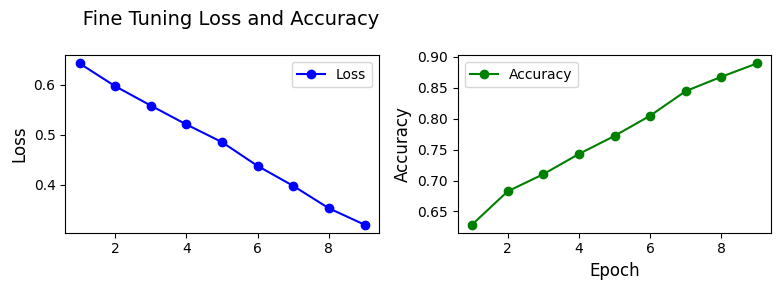

In [157]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9]
losses = l
accuracies = a

# Create subplots for losses and accuracies
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3), sharex=True)

# Plot for losses
ax1.plot(epochs, losses, marker='o', color='b', label='Loss')
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('   Fine Tuning Loss and Accuracy\n', fontsize=14)
ax1.legend()

# Plot for accuracies
ax2.plot(epochs, accuracies, marker='o', color='g', label='Accuracy')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Save the plots as images (optional)
plt.savefig('loss_accuracy_plot.png', dpi=300)

# Show the plots
plt.show()
